# Twitter Sentiment Analysis Pytorch

In [1]:
import numpy as np
import pandas as pd
import csv
import re
import imblearn
import torch
from nltk.corpus import stopwords
from gensim.parsing.porter import PorterStemmer
from gensim.utils import tokenize
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import remove_stopwords
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
import torch
from torchtext.legacy import data
# from torchtext import data
import matplotlib.pyplot as plt
import seaborn as sb
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from bokeh.models import ColumnDataSource, LabelSet
from bokeh.plotting import figure, show, output_file
from collections import Counter
from functools import reduce
! pip install captum bokeh spacy emot
import captum
import spacy
from captum.attr import LayerIntegratedGradients, TokenReferenceBase, visualization, IntegratedGradients, LayerConductance
from captum.attr import visualization as viz
from captum.attr import configure_interpretable_embedding_layer, remove_interpretable_embedding_layer
import emot
from bokeh.io import output_notebook
output_notebook()
! python -m spacy download en_core_web_sm
nlp = spacy.load('en')
%matplotlib inline

/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')


## Loading the data

In [75]:
# !curl https://raw.githubusercontent.com/dipikabaad/Sentiment_Classification_with_RNN/master/Tweets.csv --create-dirs -o .pytorch/tweets/tweets.csv
# !mkdir checkpoint
df = pd.read_csv('.pytorch/tweets/Twitter_Data.csv')
df.head()

,clean_text,category
0,when modi promised “minimum government maximum...,-1.0
1,talk all the nonsense and continue all the dra...,0.0
2,what did just say vote for modi welcome bjp t...,1.0
3,asking his supporters prefix chowkidar their n...,1.0
4,answer who among these the most powerful world...,1.0


### Exploring features

In [76]:
df.describe()

,category
count,162973.000000
mean,0.225436
std,0.781279
min,-1.000000
25%,0.000000
50%,0.000000
75%,1.000000
max,1.000000


In [77]:
df.groupby('category').describe()

clean_text                                                            \
              count unique                                                top   
category                                                                        
-1.0          35509  35509  the goal not clear confusion goal drop hint th...   
 0.0          55211  55211  mosadai modi anayam for this judgement helps a...   
 1.0          72249  72249  right strong govt can also ensure the escape r...   

               
         freq  
category       
-1.0        1  
 0.0        1  
 1.0        1

In [78]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 162980 entries, 0 to 162979
Data columns (total 2 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   clean_text  162976 non-null  object 
 1   category    162973 non-null  float64
dtypes: float64(1), object(1)
memory usage: 2.5+ MB


In [79]:
df.isnull().sum()

clean_text    4
category      7
dtype: int64

In [81]:
df[df['clean_text'].str.len() < 2]

,clean_text,category
77224,,0.0


In [82]:
df[df.duplicated('clean_text')]

,clean_text,category
158694,NaN,-1.0
159443,NaN,0.0
160560,NaN,1.0


In [83]:
df.drop_duplicates('clean_text', inplace=True)
df[df.duplicated('clean_text')]

,clean_text,category


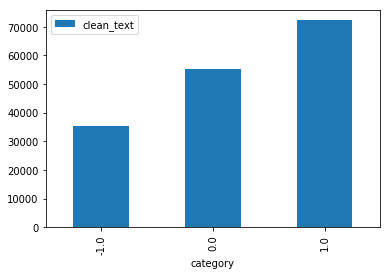

In [84]:
df[['category', 'clean_text']].groupby('category').count().plot.bar()

### Preprocessing Data

#### Steps
1. One-hot encode output
2. Replace tags and metion with a unique symbol
3. Replace `emoji` and `emoticons` with their meaning
4. Remove stop-words
5. Remove punctuation and tokenize sentences
6. Stemming each token

In [88]:

condlist = [
    df['category'] == 1, # pos
    df['category'] == 0, # neu
    df['category'] == -1 # neg
]
df['sentiment'] = np.select(condlist, [1,0,2])
d = df[['clean_text', 'sentiment']]
d.rename(columns={'clean_text': 'text'}, inplace=True)
d.head()

c:\program files\python37\lib\site-packages\pandas\core\frame.py:4304: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,text,sentiment
0,when modi promised “minimum government maximum...,2
1,talk all the nonsense and continue all the dra...,0
2,what did just say vote for modi welcome bjp t...,1
3,asking his supporters prefix chowkidar their n...,1
4,answer who among these the most powerful world...,1


In [89]:
def emoji_helper(text):
    clean_mean = lambda x:  x.replace('-', '_').replace(':', ' ')
    for emoti in emot.emo_unicode.EMOTICONS:
        if emoti in text:
            text = text.replace(emoti, clean_mean(emot.emo_unicode.EMOTICONS.get(emoti, '')))

    for emoti in emot.emo_unicode.UNICODE_EMO:
        if emoti in text:
            text = text.replace(emoti, clean_mean(emot.emo_unicode.UNICODE_EMO.get(emoti, '')))

    for emoti in emot.emo_unicode.EMOTICONS_EMO:
        if emoti in text:
            text = text.replace(emoti, clean_mean(emot.emo_unicode.EMOTICONS_EMO.get(emoti, '')).replace(' ','_'))
    return text

porter_stemmer = PorterStemmer()


def preprocess(x):
    return [porter_stemmer.stem(word) for word in
        simple_preprocess(remove_stopwords(emoji_helper(re.sub(r'\s*([@#][\w_-]+)', '', str(x)))), deacc=True)
    ]

d['text'] = d['text'].apply(func=lambda x:preprocess(x))

d

c:\program files\python37\lib\site-packages\ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,text,sentiment
0,"[modi, promis, minimum, govern, maximum, gover...",2
1,"[talk, nonsens, continu, drama, vote, modi]",0
2,"[vote, modi, welcom, bjp, told, rahul, main, c...",1
3,"[ask, support, prefix, chowkidar, name, modi, ...",1
4,"[answer, power, world, leader, todai, trump, p...",1
...,...,...
162975,"[crore, paid, neerav, modi, recov, congress, l...",2
162976,"[dear, rss, terrorist, payal, gawar, modi, kil...",2
162977,"[cover, interact, forum, left]",0
162978,"[big, project, came, india, modi, dream, proje...",0


#### Analyze review length
Here we remove the outliers

In [90]:
d['text'].str.len().describe()

count    162977.000000
mean         12.894905
std           6.987476
min           0.000000
25%           7.000000
50%          12.000000
75%          18.000000
max          42.000000
Name: text, dtype: float64

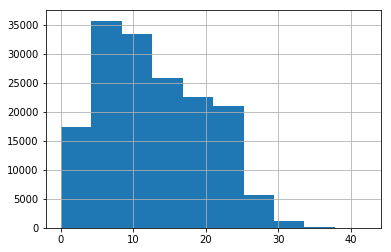

In [91]:
d['text'].str.len().hist()

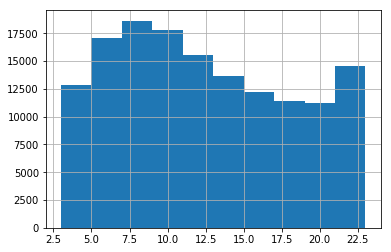

In [92]:
d = d[ (2 < d['text'].str.len()) & (d['text'].str.len() < 24) ]
d['text'].str.len().hist()

### Creating vocab

In [93]:
max_document_length = d['text'].str.len().max()  # each sentence has until 100 words
max_size = 5000
Text = data.Field(batch_first=True, tokenize=lambda x: x, include_lengths=True, fix_length=max_document_length)
Label = data.Field(sequential=False, use_vocab=False, pad_token=None, unk_token=None)
fields = [('text', Text), ('labels', Label)]

In [94]:
class DataFrameDataset(data.Dataset):

    def __init__(self, df, text_field, label_field, is_test=False, **kwargs):
        fields = [('text', text_field), ('labels', label_field)]
        examples = []
        for i, row in df.iterrows():
            label = row.sentiment
            text = row.text
            examples.append(data.Example.fromlist([text, label], fields))

        super().__init__(examples, fields, **kwargs)

    @staticmethod
    def sort_key(ex):
        return len(ex.text)

    @classmethod
    def splits(cls, text_field, label_field, train_df, test_df=None, **kwargs):
        train_data, test_data = (None, None)

        if train_df is not None:
            train_data = cls(train_df.copy(), text_field, label_field, **kwargs)
        if test_df is not None:
            test_data = cls(test_df.copy(), text_field, label_field, True, **kwargs)

        return tuple(d for d in (train_data, test_data) if d is not None)
test_size = 0.2 # split percentage to train\validation data
X_train,X_test,y_train,y_test = train_test_split(d['text'].index,d['sentiment'], test_size=test_size, random_state=0, stratify=d['sentiment'])
train_df = d.loc[X_train.values]
test_df = d.loc[X_test.values]
train_ds, test_ds = DataFrameDataset.splits(
    text_field=Text, label_field=Label, train_df=train_df, test_df=test_df)
vars(test_ds[0])

{'text': ['countri',
  'forward',
  'economi',
  'remov',
  'poverti',
  'protect',
  'countri',
  'remov',
  'modi',
  'shri'],
 'labels': 1}

### Checking how balance is our testset in comparison to trainset

In [95]:
test_df.groupby('sentiment').count()/test_df['sentiment'].count()*100

,text
sentiment,
0,34.421928
1,44.208927
2,21.369144


In [96]:
train_df.groupby('sentiment').count()/train_df['sentiment'].count()*100

,text
sentiment,
0,34.423089
1,44.206720
2,21.370192


In [107]:
items = train_df.groupby('sentiment').count().to_numpy()
neu, pos, neg = items[0][0], items[1][0], items[2][0]
total = train_df.count()[0]
weight_for_0 = (1 / neu)*(total)/2.0
weight_for_1 = (1 / pos)*(total)/2.0
weight_for_2 = (1 / neg)*(total)/2.0
print(weight_for_0, weight_for_1, weight_for_2)

1.452513476244202 1.1310497647449287 2.339707604700941


In [98]:
Text.build_vocab(train_ds, test_ds, max_size=max_size)
Label.build_vocab(train_ds)
vocab_size = len(Text.vocab)

In [99]:
PAD_IND = Text.vocab.stoi['pad']
# captum
token_reference = TokenReferenceBase(reference_token_idx=PAD_IND) # create a reference (aka baseline) for the sentences and its constituent parts, tokens

## Defining model

In [100]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [101]:
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
class LSTM(nn.Module):

    # define all the layers used in model
    def __init__(self, vocab_size, embedding_dim, hidden_dim1, hidden_dim2, output_dim, n_layers,
                 bidirectional, dropout, pad_index):
        # Constructor
        super().__init__()
        self.n_layers = n_layers
        self.hidden_dim1 = hidden_dim1
        self.bidirectional = bidirectional
        # embedding layer
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx = pad_index)

        # lstm layer
        self.lstm = nn.LSTM(embedding_dim,
                            hidden_dim1,
                            num_layers=n_layers,
                            bidirectional=bidirectional,
                            batch_first=True)
        self.fc1 = nn.Linear(hidden_dim1 * 2, hidden_dim2)
        self.fc2 = nn.Linear(hidden_dim2, output_dim)
        self.relu = nn.SELU()
        self.dropout = nn.Dropout(dropout)
        self.dropout1 = nn.Dropout(dropout)
        # activation function
        self.act = nn.Softmax() #\ F.log_softmax(outp)

    def forward(self, text, text_lengths, hid=None):
        # text = [batch size,sent_length]
        if hid == None:
            hid = self.init_hidden(text.shape[0])
        embedded = self.embedding(text)
        # embedded = [batch size, sent_len, emb dim]

        # packed sequence
        packed_embedded = pack_padded_sequence(embedded, text_lengths.cpu(), batch_first=True) # unpad

        packed_output, (hidden, cell) = self.lstm(packed_embedded, hid)
        # packed_output shape = (batch, seq_len, num_directions * hidden_size)
        # hidden shape  = (num_layers * num_directions, batch, hidden_size)

        # concat the final forward and backward hidden state
        cat = torch.cat((hidden[-2, :, :], hidden[-1, :, :]), dim=1)
        # output, output_lengths = pad_packed_sequence(packed_output)  # pad the sequence to the max length in the batch
        cat = self.dropout1(cat)
        rel = self.relu(cat)
        dense1 = self.fc1(rel)

        drop = self.dropout(dense1)
        preds = self.fc2(drop)

        # Final activation function
        # preds = self.act(preds)
        # preds = preds.argmax(dim=1).unsqueeze(0)
        return preds, (hidden, cell)
    
    def init_hidden(self, batch_size):
        ''' Initializes hidden state '''
        # Create two new tensors with sizes n_layers x batch_size x n_hidden,
        # initialized to zero, for hidden state and cell state of LSTM
        weight = next(self.parameters()).data

        hidden = (torch.zeros(self.n_layers*(2 if self.bidirectional else 1), batch_size, self.hidden_dim1).to(device),
                  torch.zeros(self.n_layers*(2 if self.bidirectional else 1), batch_size, self.hidden_dim1).to(device))

        return hidden

In [102]:

# hyper-parameters:
lr = 1e-4
batch_size = 50
dropout_keep_prob = 0.5
embedding_size = 300
seed = 0
clip=5
num_classes = 3
num_hidden_nodes = 93
hidden_dim2 = 512
num_layers = 2  # LSTM layers
bi_directional = True
num_epochs = 100

pad_index = Text.vocab.stoi[Text.pad_token]

# Build the model
lstm_model = LSTM(vocab_size, embedding_size, num_hidden_nodes, hidden_dim2 , num_classes, num_layers,
                  bi_directional, dropout_keep_prob, pad_index)
lstm_model.to(device)
print(lstm_model)

LSTM(
  (embedding): Embedding(5002, 300, padding_idx=1)
  (lstm): LSTM(300, 93, num_layers=2, batch_first=True, bidirectional=True)
  (fc1): Linear(in_features=186, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=3, bias=True)
  (relu): SELU()
  (dropout): Dropout(p=0.5, inplace=False)
  (dropout1): Dropout(p=0.5, inplace=False)
  (act): Softmax(dim=None)
)


## training the model

In [103]:
train_iterator, test_iterator = data.BucketIterator.splits((train_ds, test_ds),
                                                           batch_size=batch_size,
                                                           sort_key=lambda x: len(x.text),
                                                           # Sort the batches by text length size
                                                           sort_within_batch=True,
                                                           device=device,
                                                           )

In [104]:
def accuracy(probs, target):
    winners = probs.argmax(dim=1)
    corrects = (winners == target)
    accuracy = corrects.sum().float() / float(target.size(0))
    return accuracy

def plot_cm(y_true, y_pred, target_names):
    cm = confusion_matrix(y_true, y_pred, labels=target_names)
    plt.figure(figsize=(5,5))
    sb.heatmap(cm, annot=True, fmt="d")
    plt.title('Confusion matrix')
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')

def train(model, iterator, optimizer, criterion):
    epoch_loss = 0
    epoch_acc = 0

    model.train()
    h = model.init_hidden(batch_size)
    for batch in iterator:
        optimizer.zero_grad()
        # zero accumulated gradients
        model.zero_grad()
        # retrieve text and no. of words
        text, text_lengths = batch.text
        if (text.shape[0], text.shape[1]) != (batch_size, max_document_length):
            continue

        # Creating new variables for the hidden state, otherwise
        # we'd backprop through the entire training history
        h = tuple([each.data for each in h])

        predictions, h = model(text, text_lengths, h)
        loss = criterion(predictions, batch.labels.squeeze())

        acc = accuracy(predictions, batch.labels)

        # perform backpropagation
        loss.backward()
        # `clip_grad_norm` helps prevent the exploding gradient problem in RNNs / LSTMs.
        nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()

        epoch_loss += loss.item()
        epoch_acc += acc.item()

    return epoch_loss / len(iterator), epoch_acc / len(iterator)

def evaluate(model, iterator, criterion, report=False):
    epoch_loss = 0
    epoch_acc = 0
    report_pred_test =[]
    report_label_test =[]

    model.eval()
    val_h = model.init_hidden(batch_size)
    with torch.no_grad():
        for batch in iterator:
            text, text_lengths = batch.text
            if (text.shape[0], text.shape[1]) != (batch_size, max_document_length):
                continue

            # Creating new variables for the hidden state, otherwise
            # we'd backprop through the entire training history
            val_h = tuple([each.data for each in val_h])

            predictions, val_h = model(text, text_lengths, val_h)

            loss = criterion(predictions, batch.labels)

            acc = accuracy(predictions, batch.labels)
            if report:
                report_pred_test.extend(predictions.argmax(dim=1).cpu())
                report_label_test.extend(batch.labels.cpu())

            epoch_loss += loss.item()
            epoch_acc += acc.item()
    if report:
        print(classification_report(report_label_test, report_pred_test, target_names=['neutral', 'positive', 'negative']))
        plot_cm(report_label_test, report_pred_test, target_names=[0, 1, 2])

    return epoch_loss / len(iterator), epoch_acc / len(iterator)


def run_train(epochs, model, train_iterator, valid_iterator, optimizer, criterion):
    best_valid_loss = float('inf')

    for epoch in range(epochs):

        # train the model
        train_loss, train_acc = train(model, train_iterator, optimizer, criterion)

        # evaluate the model
        valid_loss, valid_acc = evaluate(model, valid_iterator, criterion)

        # save the best model
        if valid_loss < best_valid_loss:
            best_valid_loss = valid_loss
            torch.save(model.state_dict(), 'checkpoint/twitter.t7')

        print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc * 100:.2f}%')
        print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc * 100:.2f}%')

In [105]:
# loss function
loss_func = nn.CrossEntropyLoss(weight=torch.tensor([weight_for_0, weight_for_1, weight_for_2], dtype=torch.float32, device=device))
optimizer = torch.optim.Adam(lstm_model.parameters(), lr=lr)

In [106]:
run_train(num_epochs, lstm_model, train_iterator, test_iterator, optimizer, loss_func)

KeyboardInterrupt: 

In [ ]:
lstm_model.load_state_dict(torch.load('checkpoint/twitter.t7', map_location=device))
# predict
test_loss, test_acc = evaluate(lstm_model, test_iterator, loss_func, report=True)
print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc * 100:.2f}%')

If the model is predicted perfectly confusion matrix should be diagonal which indicates values off the main diagonal representing incorrect prediction is zero

## Visualizing the model

In [ ]:
vis_data_records_ig = []
def forward(input, text_length):
    return F.softmax(lstm_model(input, text_length)[0])
lig = LayerIntegratedGradients(forward, lstm_model.embedding)
def interpret_sentence(model, sentence, min_len = max_document_length, label = 0):
    model.train()
    h = model.init_hidden(1)
    h500 = model.init_hidden(500)
    text = preprocess(sentence)
    actual_len = len(text)
    if len(text) < min_len:
        text += ['<pad>'] * (min_len - len(text))
    indexed = [Text.vocab.stoi[t] for t in text]

    model.zero_grad()

    input_indices = torch.tensor(indexed, device=device)
    input_indices = input_indices.unsqueeze(0)
    text_length = torch.tensor([actual_len], device=device)
    # input_indices dim: [sequence_length]
    seq_length = min_len

    # predict
    pred = F.softmax(model(input_indices, text_length, h)[0]).argmax(dim=1).item()
    pred_ind = round(pred)

    # generate reference indices for each sample
    reference_indices = token_reference.generate_reference(seq_length, device=device).unsqueeze(0)

    # compute attributions and approximation delta using layer integrated gradients
    attributions_ig, delta = lig.attribute(input_indices, reference_indices,
                                           n_steps=500,target=2-label, return_convergence_delta=True, additional_forward_args=text_length)

    print(sentence, 'pred: ', {1:'positive', 0: 'netural', 2: 'negative'}[pred_ind], '(', '%.2f'%pred, ')', ', delta: ', abs(delta))

    add_attributions_to_visualizer(attributions_ig, text, pred, pred_ind, label, delta, vis_data_records_ig)

def add_attributions_to_visualizer(attributions, text, pred, pred_ind, label, delta, vis_data_records):
    attributions = attributions.sum(dim=2).squeeze(0)
    attributions = attributions / torch.norm(attributions)
    attributions = attributions.cpu().detach().numpy()


    # storing couple samples in an array for visualization purposes
    vis_data_records.append(visualization.VisualizationDataRecord(
        attributions,
        pred,
        {1:'positive', 0: 'netural', 2: 'negative'}[pred_ind],
        {1:'positive', 0: 'netural', 2: 'negative'}[label],
        {1:'positive', 0: 'netural', 2: 'negative'}[label],
        attributions.sum(),
        text,
        delta))

In [ ]:
interpret_sentence(lstm_model, 'It was a fantastic performance !', label=1)
interpret_sentence(lstm_model, 'Best film ever', label=1)
interpret_sentence(lstm_model, 'Such a great show!', label=1)
interpret_sentence(lstm_model, 'It was a horrible movie', label=2)
interpret_sentence(lstm_model, 'I\'ve never watched something as bad', label=2)
interpret_sentence(lstm_model, 'It is a disgusting movie!', label=2)
interpret_sentence(lstm_model, 'normal', label=0)

In [ ]:
_ = visualization.visualize_text(vis_data_records_ig)

In [ ]:
vis_word = []
colorlist= []
def interpret_word(model, word, min_len = max_document_length, label = 0):
    model.train()
    text = preprocess(word)
    actual_len = 1
    if len(text) < min_len:
        text += ['<pad>'] * (min_len - len(text))
    indexed = [Text.vocab.stoi[t] for t in text]

    model.zero_grad()

    input_indices = torch.tensor(indexed, device=device)
    input_indices = input_indices.unsqueeze(0)
    text_length = torch.tensor([actual_len], device=device)
    # input_indices dim: [sequence_length]
    seq_length = min_len

    # predict
    pred = F.softmax(model(input_indices, text_length)[0]).cpu()


    vis_word.append(pred.detach().numpy().squeeze(0))
    colorlist.append({0:'#00ff00', 1: '#00ffff', 2:'#000000' }[pred.argmax(dim=1).item()])

In [ ]:
for i in Text.vocab.itos:
    interpret_word(lstm_model, i)

In [ ]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, random_state=0)
words_top_ted_tsne = tsne.fit_transform(vis_word)

In [ ]:
p = figure(tools="pan,wheel_zoom,reset,save",
           toolbar_location="above",
           title="vector T-SNE for most polarized words")

source = ColumnDataSource(data=dict(x1=words_top_ted_tsne[:,0],
                                    x2=words_top_ted_tsne[:,1],
                                    names=Text.vocab.itos,
                                    color=colorlist))

p.scatter(x="x1", y="x2", size=8, source=source, fill_color="color")

word_labels = LabelSet(x="x1", y="x2", text="names", y_offset=6,
                       text_font_size="8pt", text_color="#555555",
                       source=source, text_align='center',render_mode='canvas')
# p.add_layout(word_labels)

show(p)


In [ ]:
p = figure(tools="pan,wheel_zoom,reset,save",
           toolbar_location="above",
           title="vector T-SNE for most polarized words")

source = ColumnDataSource(data=dict(x1=words_top_ted_tsne[:,0],
                                    x2=words_top_ted_tsne[:,1],
                                    names=Text.vocab.itos,
                                    color=colorlist))

p.scatter(x="x1", y="x2", size=8, source=source, fill_color="color")

word_labels = LabelSet(x="x1", y="x2", text="names", y_offset=6,
                       text_font_size="8pt", text_color="#555555",
                       source=source, text_align='center',render_mode='canvas')
p.add_layout(word_labels)

show(p)